In [46]:
import fcsparser
import matplotlib.pyplot as plt

In [66]:
path_to_fcs = "Dados_FCS/LD1_PI+PI_D01_exp.fcs"
meta, data = fcsparser.parse(path_to_fcs, reformat_meta=True)

In [59]:
data.columns

Index(['FSC-A', 'FSC-H', 'SSC-A', 'AARD-A', 'HLA-DR', 'p-ERK1_2', 'Blank',
       'CD3', 'Perforin', 'CD38', 'IFNg', 'CD4', 'CD8', 'Time'],
      dtype='object')

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.widgets import RectangleSelector, EllipseSelector
import pandas as pd
import tkinter as tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import numpy as np
from matplotlib.patches import Ellipse
from matplotlib.path import Path
from scipy.stats import gaussian_kde

selected_points = []
df_plot = None  # Definição global
axis = None  # Definição global
selector = None  # Definição global para o selector
current_tool = "rectangle"  # Ferramenta padrão
polygon_points = []
polygon_path = None

def clear_selector():
    global selector
    if selector:
        selector.set_active(False)
        selector = None

def onselect_rectangle(eclick, erelease):
    global selected_points, df_plot, axis
    x_min, x_max = sorted([eclick.xdata, erelease.xdata])
    y_min, y_max = sorted([eclick.ydata, erelease.ydata])
    selected_points = df_plot[(df_plot[axis[0]] >= x_min) & (df_plot[axis[0]] <= x_max) &
                              (df_plot[axis[1]] >= y_min) & (df_plot[axis[1]] <= y_max)]
    print("Selected region:")
    print(selected_points)

def onselect_ellipse(eclick, erelease):
    global selected_points, df_plot, axis
    x_center = (eclick.xdata + erelease.xdata) / 2
    y_center = (eclick.ydata + erelease.ydata) / 2
    width = abs(eclick.xdata - erelease.xdata)
    height = abs(eclick.ydata - erelease.ydata)
    angle = np.degrees(np.arctan2(erelease.ydata - eclick.ydata, erelease.xdata - eclick.xdata))
    
    ellipse_patch = Ellipse((x_center, y_center), width, height, angle=angle)
    inside_ellipse = np.array([ellipse_patch.contains_point((row[axis[0]], row[axis[1]])) for _, row in df_plot.iterrows()])
    selected_points = df_plot[inside_ellipse]
    print("Selected region:")
    print(selected_points)

def onclick_polygon(event):
    global polygon_points, polygon_path, df_plot, axis, selected_points
    if event.xdata is not None and event.ydata is not None:
        polygon_points.append((event.xdata, event.ydata))
        if len(polygon_points) > 1:
            x_vals, y_vals = zip(*polygon_points)
            ax.plot(x_vals, y_vals, marker='o', linestyle='-', color='r')
            canvas.draw()
    

def finalize_polygon():
    global polygon_points, polygon_path, df_plot, axis, selected_points
    if len(polygon_points) > 2:
        polygon_points.append(polygon_points[0])  # Fechar o polígono
        x_vals, y_vals = zip(*polygon_points)
        ax.plot(x_vals, y_vals, marker='o', linestyle='-', color='r')
        polygon_path = Path(polygon_points)
        
        points = np.column_stack((df_plot[axis[0]], df_plot[axis[1]]))
        inside_polygon = polygon_path.contains_points(points)
        selected_points = df_plot[inside_polygon]
        print("Selected region:")
        print(selected_points)
        canvas.draw()
    polygon_points = []  # Resetar para um novo polígono

def set_tool(tool_name, ax, canvas):
    global selector, current_tool
    clear_selector()
    current_tool = tool_name
    
    if tool_name == "rectangle":
        selector = RectangleSelector(ax, onselect_rectangle, useblit=True, button=[1], interactive=True)
    elif tool_name == "ellipse":
        selector = EllipseSelector(ax, onselect_ellipse, useblit=True, button=[1], interactive=True)
    elif tool_name == "polygon":
        canvas.mpl_connect('button_press_event', onclick_polygon)
    
    canvas.draw()

def plot_fcs(df, biparameter: bool, axis_param: tuple, threshold: dict = {}, cutoff: int = 0, labels: tuple = (), plot_type: str = "scatter", interactive: bool = False):
    global df_plot, axis, selector, ax, canvas
    df_plot = df.copy()
    axis = axis_param  
    
    if cutoff != 0:
        df_plot = df.head(cutoff)
        
    if len(threshold) != 0:
        for key, value in zip(threshold.keys(), threshold.values()):
            filter_df = (df_plot[key] >= int(value[0])) & (df_plot[key] <= int(value[1]))
            df_plot = df_plot[filter_df]
    
    if biparameter:
        x = df_plot[axis[0]]
        y = df_plot[axis[1]]
        
        root = tk.Tk()
        root.title("Interactive Plot Selector")
        
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.grid()
        
        if plot_type == "density":
            xy = np.vstack([x, y])
            density = gaussian_kde(xy)(xy)
            scatter = ax.scatter(x, y, c=density, cmap='Blues', s=10, edgecolors='black')
            cbar = plt.colorbar(scatter, ax=ax)
            cbar.set_ticks([])  

        else:
            ax.scatter(x, y, s=10, edgecolors='black')
        
        if len(labels) > 0:
            ax.set_xlabel(labels[0])
            ax.set_ylabel(labels[1])
        else:
            ax.set_xlabel(axis[0])
            ax.set_ylabel(axis[1])
        
        canvas = FigureCanvasTkAgg(fig, master=root)
        canvas.get_tk_widget().pack()
        canvas.draw()
        
        button_frame = tk.Frame(root)
        button_frame.pack()
        
        tk.Button(button_frame, text="Retângulo", command=lambda: set_tool("rectangle", ax, canvas)).pack(side=tk.LEFT)
        tk.Button(button_frame, text="Elipse", command=lambda: set_tool("ellipse", ax, canvas)).pack(side=tk.LEFT)
        tk.Button(button_frame, text="Polígono", command=lambda: set_tool("polygon", ax, canvas)).pack(side=tk.LEFT)
        tk.Button(button_frame, text="Finalizar Polígono", command=finalize_polygon).pack(side=tk.LEFT)
        
        def close_window():
            root.destroy()
        
        close_button = tk.Button(root, text="Confirm Selection", command=close_window)
        close_button.pack()
        
        root.mainloop()
        
        return selected_points
    
    plt.show()


In [62]:
threshold = {
   'FSC-A':(0,50000),
   'FSC-H':(0,50000)
}

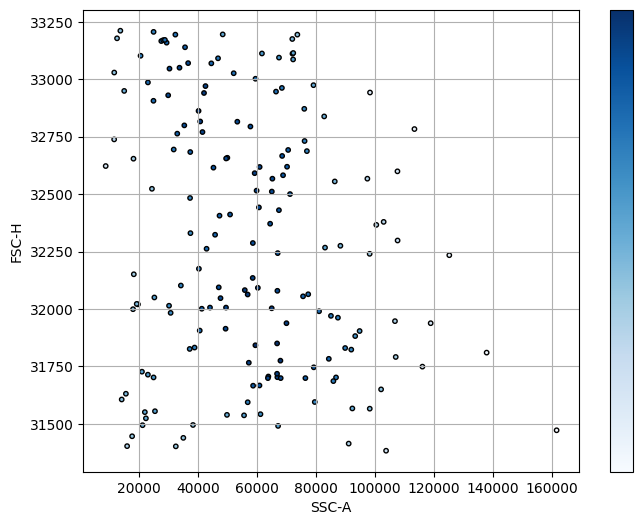

In [65]:
data = plot_fcs(data,True,('SSC-A','FSC-H'),plot_type='density',interactive=False,threshold=threshold)

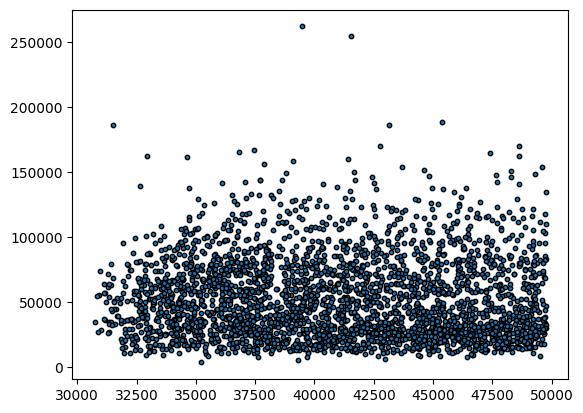

In [53]:
plt.scatter(data['FSC-A'],data['SSC-A'],edgecolors='black',s=10)

In [54]:
data

,FSC-A,FSC-H,SSC-A,AARD-A,HLA-DR,p-ERK1_2,Blank,CD3,Perforin,CD38,IFNg,CD4,CD8,Time
131,41389.921875,36709.0,45182.25,192.00,2133.320068,57.00,764.559998,377.720001,121.680008,4295.520020,1349.280029,121.680008,148.50,0.074965
212,47283.121094,42247.0,100648.50,9288.75,893.000000,790.50,470.440002,269.040009,622.080017,2079.360107,839.520020,996.480042,3444.00,0.108948
289,45175.683594,41269.0,51595.50,633.00,1611.199951,156.75,85.119995,90.440002,46.800003,102.240005,981.360046,79.920006,307.50,0.137935
315,38517.121094,35983.0,14261.25,2640.00,232.559998,26.25,49.399998,452.959991,8.640000,82.080002,152.639999,28.080002,1472.25,0.145931
475,43728.480469,40178.0,22010.25,1080.75,2015.520020,22.50,87.400002,97.279999,61.920002,361.440002,881.280029,39.600002,304.50,0.194908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244484,47058.480469,43719.0,42033.75,524.25,621.679993,73.50,76.760002,65.360001,41.760002,149.040009,378.000000,41.760002,528.00,94.802132
244492,45203.042969,41927.0,13254.75,2488.50,132.240005,43.50,31.160000,294.119995,298.800018,663.120056,170.639999,1127.520020,623.25,94.806129
244510,35375.042969,31403.0,15879.75,866.25,188.479996,36.75,55.480000,324.519989,474.480011,1221.840088,304.559998,1941.120117,301.50,94.815125
244523,40075.203125,36741.0,78296.25,10927.50,737.959961,303.00,446.880005,165.679993,4631.040039,3064.320068,1122.480103,1890.720093,2955.00,94.821121


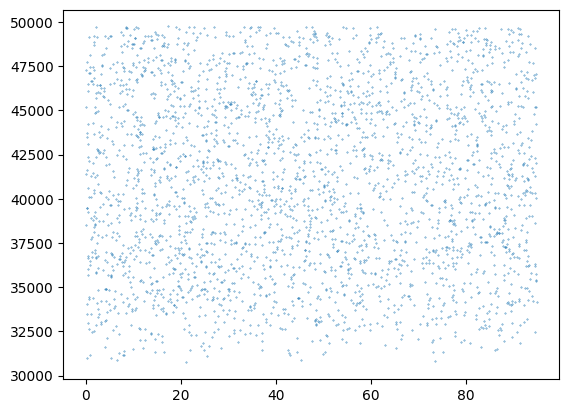

In [55]:
plt.scatter(data['Time'],data['FSC-A'],s=0.1)